In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

## Check controls: in-vitro array, and naked plasmid

#### The plasmid contains a part of the sequence of the ARS305 locus

In [2]:
wt_rep3_nucarray = np.loadtxt("controls/wt_mat_Megalodon_repIII_in_vitro_nucl_array.txt")
wt_rep3_nucarray.shape

(780, 1966)

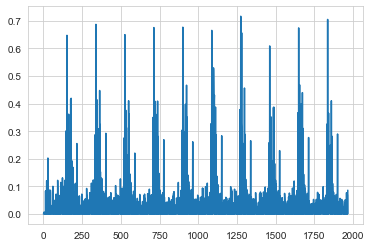

In [3]:
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), y = np.mean(wt_rep3_nucarray, axis = 0))
plt.show()

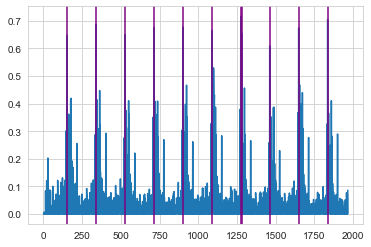

In [4]:
peaks = np.where(np.mean(wt_rep3_nucarray, axis = 0) >0.6)

sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), y = np.mean(wt_rep3_nucarray, axis = 0))
for position in peaks[0]:
    plt.axvline(position, color = "purple")
plt.show()

In [5]:
np.gradient(peaks[0]).mean()

170.0

Text(0.5, 1.0, 'wt rep nuc array')

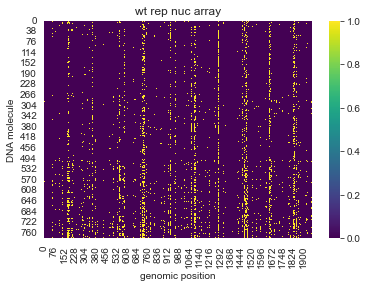

In [6]:
#heatmap of the wt raw data
sns.heatmap(wt_rep3_nucarray, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt rep nuc array")

### Test differrent window sizes for smoothing

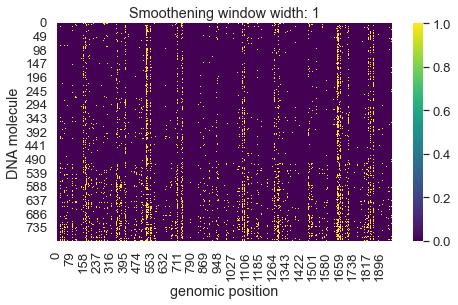

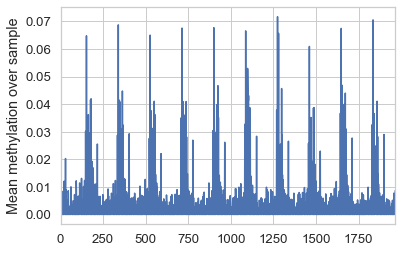

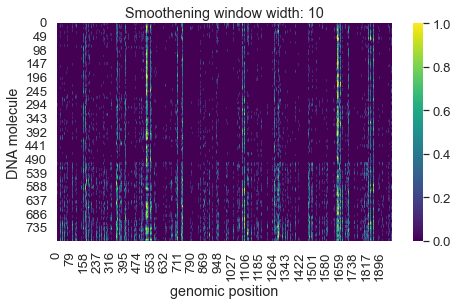

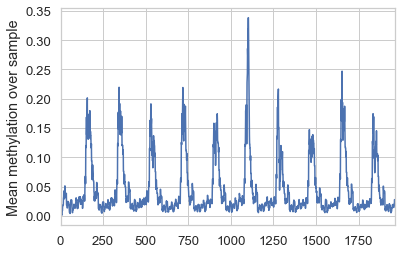

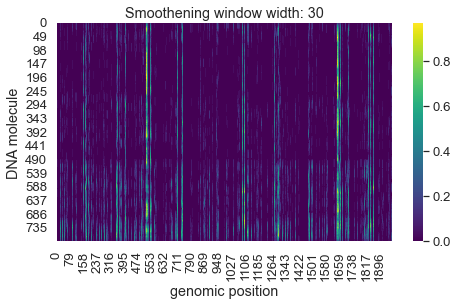

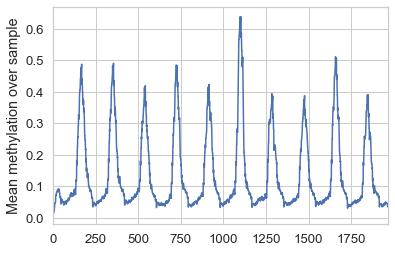

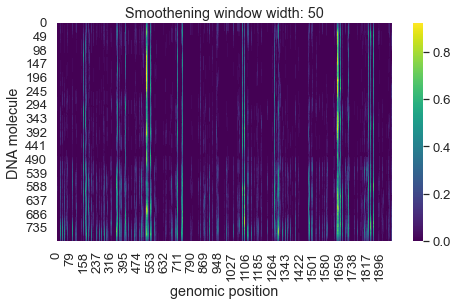

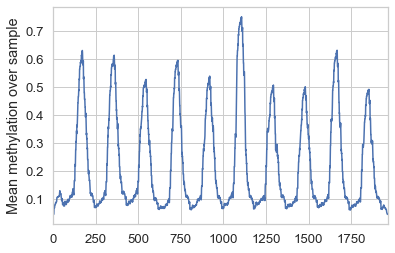

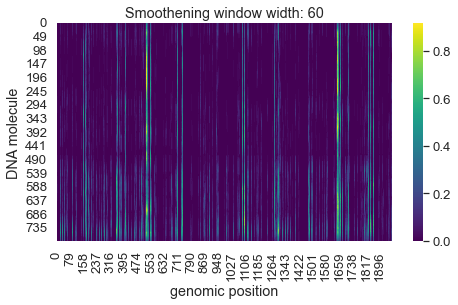

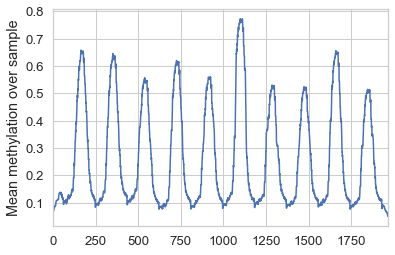

In [82]:
#calculate a sliding mean for each molecule
np.convolve(wt_rep3_nucarray[0,:], np.ones(10)/10, mode='same').shape

#N = 20 #smoothening window

#def smooth(array):
 #   return np.convolve(array, np.ones(N)/N, mode = "same")

for N in [1, 10, 30, 50, 60]:
    
    def smooth(array):
        return np.convolve(array, np.ones(N)/N, mode = "same")
    
    wt_nucarray_smooth = np.apply_along_axis(smooth, 0, wt_rep3_nucarray)
    
    plt.figure(figsize=(7.5,4))
    sns.heatmap(wt_nucarray_smooth, cmap = "viridis")
    plt.xlabel("genomic position")
    plt.ylabel("DNA molecule")
    plt.xlim(0, 1966)
    plt.title("Smoothening window width: " + str(N))
    plt.show()

    sns.lineplot(x = range(wt_nucarray_smooth.shape[1]), 
                 y = np.convolve(wt_nucarray_smooth.mean(axis = 0), np.ones(N)/10, mode ="same")
                )
    plt.ylabel("Mean methylation over sample")
    plt.xlim(0, 1966)
    plt.show()

### Load the other replicate, and the counts from the mutants dies6 and disw2:

In [7]:
wt_rep2_nucarray = np.loadtxt("controls/mat_Megalodon_repII_in_vitro_nucl_array.txt")

dies6_rep1_nucarray = np.loadtxt("controls/DIES6_ALL_REP1_in_vitro_nucl_array.txt")
dies6_rep2_nucarray = np.loadtxt("controls/DIES6_REP2_780READS_in_vitro_nucl_array.txt")

disw2_rep1_nucarray = np.genfromtxt("controls/array_disw2_rep1_780READS_noNA.csv",
                                   dtype = int, delimiter = ",")

disw2_rep2_nucarray = np.loadtxt("controls/array_disw2_rep2_780READS_noNA_cleaned.csv")

In [9]:
#load the data for the minus strand:

wt_rep3_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_repIII_in_vitro_nucl_array_minus.txt") #780 reads
wt_rep2_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_repII_in_vitro_nucl_array_minus.txt") #780 reads

dies6_rep1_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_in_vitro_nucl_array_minus.txt") #780 reads
dies6_rep2_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_in_vitro_nucl_array_minus.txt") #780 reds

disw2_rep1_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_in_vitro_nucl_array_minus.txt") 
disw2_rep2_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_in_vitro_nucl_array_minus.txt") #780 reads


In [10]:
print(wt_rep3_nucarray.shape, wt_rep3_nucarray_rev.shape)
print(wt_rep2_nucarray.shape, wt_rep2_nucarray_rev.shape)
print(dies6_rep1_nucarray.shape, dies6_rep1_nucarray_rev.shape)
print(dies6_rep2_nucarray.shape, dies6_rep2_nucarray_rev.shape)
print(disw2_rep1_nucarray.shape, disw2_rep1_nucarray_rev.shape)
print(disw2_rep2_nucarray.shape, disw2_rep2_nucarray_rev.shape)

#subsample wt_rep2 plus strand to 780 bases
#to join fw +rev, 

(780, 1966) (780, 1970)
(1000, 1966) (780, 1970)
(780, 1966) (780, 1970)
(780, 1966) (780, 1970)
(780, 1966) (780, 1970)
(780, 1966) (780, 1970)


In [11]:
### to join the data for plus and minus strand, delete the first 4 positions for the reverse strand

def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]


wt_rep2_nucarray_sub = subsample(wt_rep2_nucarray, 780)
#subsample dies6_rep2_rev to 715 reads
wt_rep3_join = np.concatenate((wt_rep3_nucarray, wt_rep3_nucarray_rev[:,:-4]), axis = 0)
wt_rep2_join = np.concatenate((wt_rep2_nucarray_sub, wt_rep2_nucarray_rev[:,:-4]), axis = 0)

dies6_rep1_join = np.concatenate((dies6_rep1_nucarray, dies6_rep1_nucarray_rev[:,:-4]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2_nucarray, dies6_rep2_nucarray_rev[:,:-4]), axis = 0)

disw2_rep1_join = np.concatenate((disw2_rep1_nucarray, disw2_rep1_nucarray_rev[:,:-4]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2_nucarray, disw2_rep2_nucarray_rev[:,:-4]), axis = 0)

In [12]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
summary["97%"] = [np.percentile(array_dic[sample].mean(axis=0), 97) for sample in summary.index]
summary["top 3% average"] = [array_dic[sample].mean(axis=0)[(array_dic[sample].mean(axis=0) > np.percentile(array_dic[sample].mean(axis=0), 97))].mean(axis=0) for sample in summary.index]

print("Summary nucleosomal array, both strands")
summary

Summary nucleosomal array, both strands


,count,mean,std,min,25%,50%,75%,max,#molecules,97%,top 3% average
wt_rep3,1966.0,0.047172,0.064389,0.0,0.014103,0.023718,0.044872,0.362821,1560,0.261635,0.306997
wt_rep2,1966.0,0.034875,0.045964,0.0,0.010256,0.018590,0.037660,0.303846,1560,0.184038,0.229694
dies6_rep1,1966.0,0.051133,0.056302,0.0,0.017308,0.029487,0.064103,0.325641,1560,0.219295,0.259767
dies6_rep2,1966.0,0.045146,0.058390,0.0,0.012821,0.021795,0.046154,0.340385,1560,0.224551,0.270752
disw2_rep1,1966.0,0.061304,0.064152,0.0,0.017949,0.036859,0.080128,0.333974,1560,0.241699,0.274967
disw2_rep2,1966.0,0.059143,0.061783,0.0,0.019231,0.035256,0.075641,0.346154,1560,0.228878,0.270937


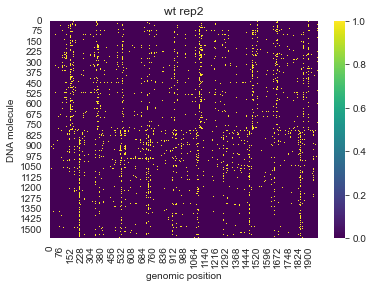

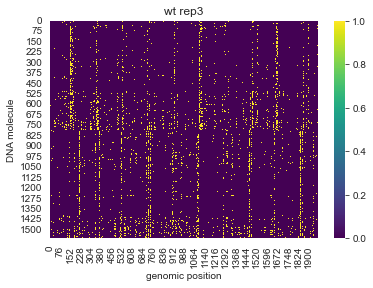

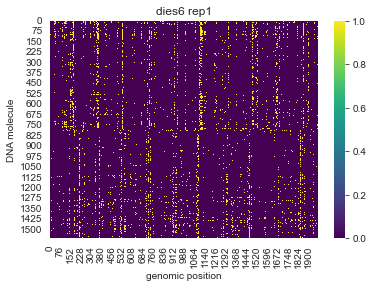

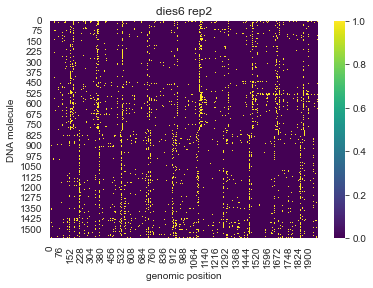

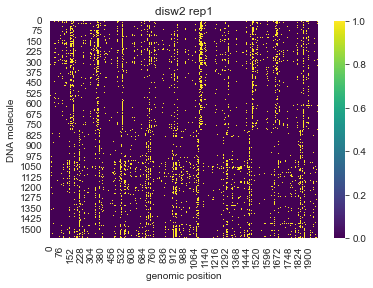

Text(0.5, 1.0, 'disw2 rep2')

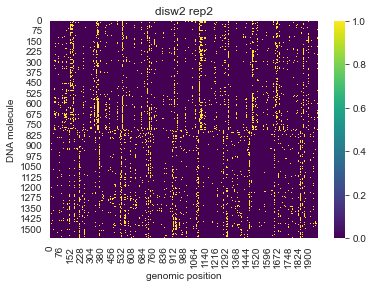

In [13]:
sns.heatmap(wt_rep2_join, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt rep2")
plt.show()

sns.heatmap(wt_rep3_join, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt rep3")
plt.show()

sns.heatmap(dies6_rep1_join, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("dies6 rep1")
plt.show()

sns.heatmap(dies6_rep2_join, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("dies6 rep2")
plt.show()

sns.heatmap(disw2_rep1_join, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("disw2 rep1")
plt.show()

sns.heatmap(disw2_rep2_join, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("disw2 rep2")

### compare replicates smoothed mean and variance of wildtype and mutants dies6 and disw2

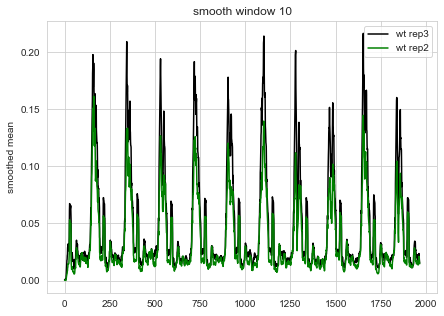

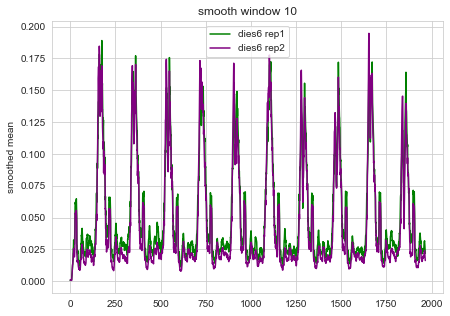

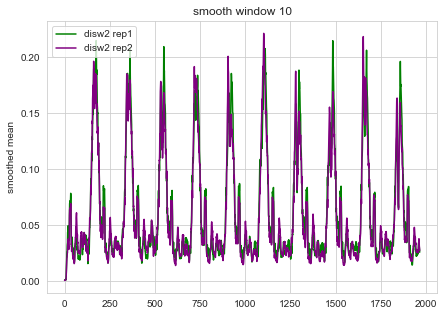

In [15]:
smooth = 10

#wildtype
fig, ax1 = plt.subplots(figsize = (7,5))
sns.lineplot(x = range(wt_rep3_join.shape[1]), 
                 y = np.convolve(wt_rep3_join.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "black", label = "wt rep3", ax = ax1)
sns.lineplot(x = range(wt_rep2_join.shape[1]), 
                 y = np.convolve(wt_rep2_join.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "green", label = "wt rep2", ax = ax1)
ax1.set_ylabel("smoothed mean")
ax1.set_title("smooth window " + str(smooth))
plt.show()

#DIES6
fig, ax1 = plt.subplots(figsize = (7,5))
sns.lineplot(x = range(wt_rep3_join.shape[1]), 
                 y = np.convolve(dies6_rep1_join.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "green", label = "dies6 rep1", ax = ax1)
sns.lineplot(x = range(wt_rep3_join.shape[1]), 
                 y = np.convolve(dies6_rep2_join.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "purple", label = "dies6 rep2", ax = ax1)
ax1.set_ylabel("smoothed mean")
ax1.set_title("smooth window " + str(smooth))
plt.show()

#DISW2
fig, ax1 = plt.subplots(figsize = (7,5))
sns.lineplot(x = range(wt_rep3_join.shape[1]), 
                 y = np.convolve(disw2_rep1_join.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "green", label = "disw2 rep1", ax = ax1)
sns.lineplot(x = range(wt_rep3_join.shape[1]), 
                 y = np.convolve(disw2_rep2_join.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "purple", label = "disw2 rep2", ax = ax1)
ax1.set_ylabel("smoothed mean")
ax1.set_title("smooth window " + str(smooth))
plt.show()

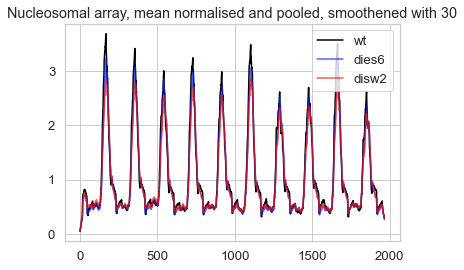

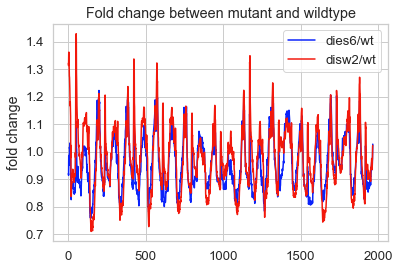

In [167]:
# Normalize the replicates to mean methylation of the sample, plot the smoothed mean and 
#export data for external plotting for manuscript

wt_rep3_minmax = wt_rep3_join.mean(axis = 0)/wt_rep3_nucarray.mean()
wt_rep2_minmax = wt_rep2_join.mean(axis = 0)/wt_rep2_nucarray.mean()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1_join.mean(axis = 0)/dies6_rep1_nucarray.mean()
dies6_rep2_minmax = dies6_rep2_join.mean(axis = 0)/dies6_rep2_nucarray.mean()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), 
                              axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1_join.mean(axis = 0)/disw2_rep1_nucarray.mean()
disw2_rep2_minmax = disw2_rep2_join.mean(axis = 0)/disw2_rep2_nucarray.mean()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)


N=30
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), 
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"),
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Nucleosomal array, mean normalised and pooled, smoothened with " + str(N)) 
#plt.savefig("controls/nucarray_scaled_pooled_data.png", dpi = 300)
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#0a22fa", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#f2180c",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

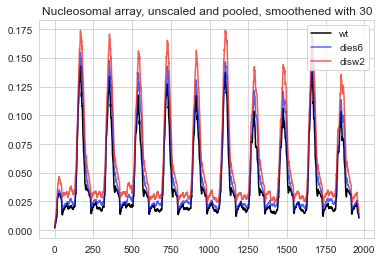

In [16]:
#Compare to non-scaled data:

unscaled_disw2_pooled = np.concatenate((disw2_rep1_join, disw2_rep2_join), axis = 0).mean(axis = 0)
unscaled_dies6_pooled = np.concatenate((dies6_rep1_join, dies6_rep2_join), axis = 0).mean(axis = 0)
unscaled_wt_pooled = np.concatenate((wt_rep3_join, wt_rep2_join), axis = 0).mean(axis = 0)

N=30
sns.lineplot(x = range(wt_rep3_join.shape[1]),
             y = np.convolve(unscaled_wt_pooled, np.ones(N)/N, mode="same"), 
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_join.shape[1]),
             y = np.convolve(unscaled_dies6_pooled, np.ones(N)/N, mode="same"),
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_join.shape[1]),
            y = np.convolve(unscaled_disw2_pooled, np.ones(N)/N, mode = "same"), 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Nucleosomal array, unscaled and pooled, smoothened with " + str(N)) 
plt.show()
#plt.savefig("controls/nucarray_pooled_data.png", dpi = 300)

## Test whether the efficiency is sequence dependent

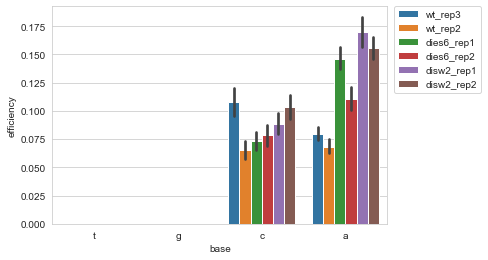

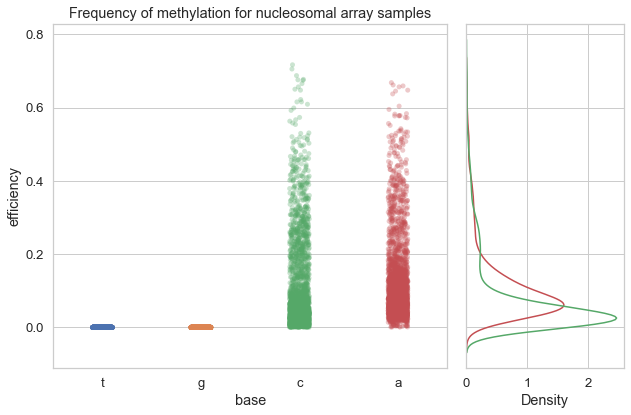

In [17]:
#bases that instead match the fw strand: 32-1997
seq="tgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagttaactacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcctaggccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagatgcatacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcttaagccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagcttataacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgagatctccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctgtatacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgccatggccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctggccacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgtgatcaccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctaggcctgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcggggcccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctctctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgacatgtccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagtactgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgggatccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctacagctgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcatatgccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctttaaacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgggtaccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagc"
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_nucarray.mean(axis=0)}, index=range(1966))


eff_df["base"] = [letter for letter in seq]
eff_df["wt_rep2"]    = wt_rep2_nucarray.mean(axis=0)
eff_df["dies6_rep1"] = dies6_rep1_nucarray.mean(axis=0)
eff_df["dies6_rep2"] = dies6_rep2_nucarray.mean(axis=0)
eff_df["disw2_rep1"] = disw2_rep1_nucarray.mean(axis=0)
eff_df["disw2_rep2"] = disw2_rep2_nucarray.mean(axis=0)

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

sns.barplot(data = eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.3, ax= axs[0])
axs[0].set_title("Frequency of methylation for nucleosomal array samples")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()

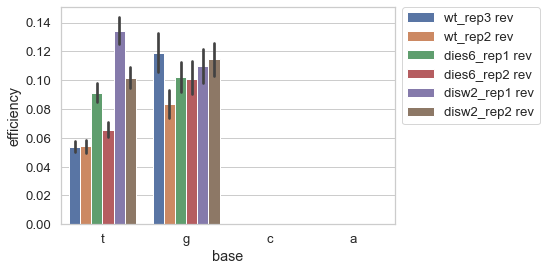

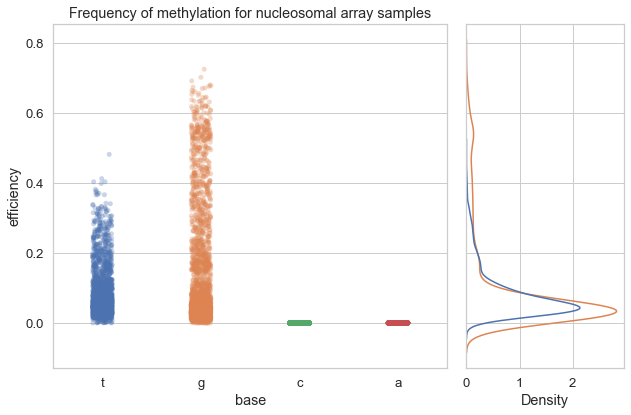

In [18]:
#check the same for the reverse read:

seq="tgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagttaactacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcctaggccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagatgcatacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcttaagccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagcttataacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgagatctccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctgtatacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgccatggccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctggccacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgtgatcaccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctaggcctgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcggggcccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctctctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgacatgtccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagtactgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgggatccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctacagctgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcatatgccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctttaaacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgggtaccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtg"
eff_df = pd.DataFrame({"wt_rep3 rev": wt_rep3_nucarray_rev.mean(axis=0)}, index=range(1970))


eff_df["base"] = [letter for letter in seq]
eff_df["wt_rep2 rev"]    = wt_rep2_nucarray_rev.mean(axis=0)
eff_df["dies6_rep1 rev"] = dies6_rep1_nucarray_rev.mean(axis=0)
eff_df["dies6_rep2 rev"] = dies6_rep2_nucarray_rev.mean(axis=0)
eff_df["disw2_rep1 rev"] = disw2_rep1_nucarray_rev.mean(axis=0)
eff_df["disw2_rep2 rev"] = disw2_rep2_nucarray_rev.mean(axis=0)

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

sns.barplot(data = eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.3, ax= axs[0])
axs[0].set_title("Frequency of methylation for nucleosomal array samples")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()

## Check the negative control: "naked plasmid" -> plasmid without aggregated nucleosomes

#### Purified plasmid was added after locus purification. Does it have ~uniform methylation?

In [19]:
wt_rep3_naked_plasmid = np.loadtxt("controls/wt_mat_Megalodon_repIII_naked_plasmid.txt")
#wt_rep2_naked_plasmid = np.loadtxt("controls/mat_Megalodon_repII_naked_plasmid.txt")

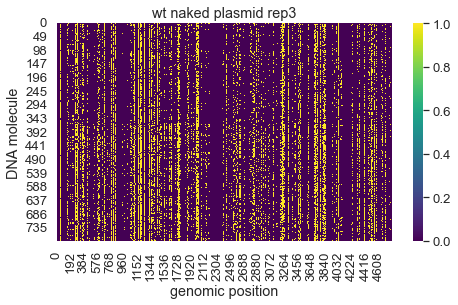

In [20]:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_naked_plasmid, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt naked plasmid rep3")
plt.show()

In [22]:
wt_rep2_naked_plasmid = np.loadtxt("controls/naked_plasmid_wt_rep2_1000reads.txt") #1000 reads
#np.random.seed(0)
#wt_rep2_naked_plasmid = subsample(wt_rep2_naked_plasmid, 780)
wt_rep2_naked_plasmid = wt_rep2_naked_plasmid[:780,:]

dies6_rep1_naked = np.loadtxt("controls/DIES6_ALL_REP1_naked_plasmid.txt")
dies6_rep2_naked = np.loadtxt("controls/DIES6_rep2_780READS_naked_plasmid.txt")

disw2_rep1_naked = np.loadtxt("controls/naked_plasmid_disw2_rep1_clean_780READS.csv")
disw2_rep2_naked = np.loadtxt("controls/naked_plasmid_disw2_rep2_clean_780_reads.csv")

#Load methylation data for the minus strand:

wt_rep3_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_repIII_naked_plasmid_minus.txt")
wt_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_repII_naked_plasmid_minus.txt")

dies6_rep1_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_naked_plasmid_minus.txt")
dies6_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_naked_plasmid_minus.txt")

disw2_rep1_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_naked_plasmid_minus.txt")
disw2_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_naked_plasmid_minus.txt")

Text(0.5, 1.0, 'wt naked plasmid rep2 minus')

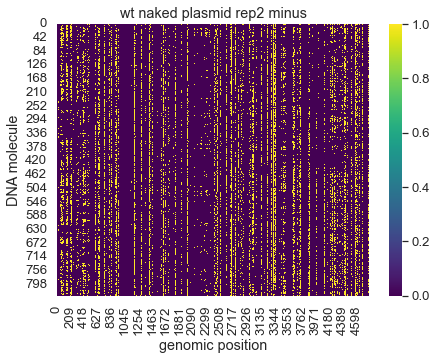

In [24]:
fig, ax1= plt.subplots(figsize = (7,5))
sns.heatmap(wt_rep2_plasmid_rev, cmap = "viridis", ax =ax1)
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
ax1.set_title("wt naked plasmid rep2 minus")

In [25]:
wt_rep3_plasmid_join = np.concatenate((wt_rep3_naked_plasmid, wt_rep3_plasmid_rev[:, :-1]), axis = 0)
wt_rep2_plasmid_join = np.concatenate((wt_rep2_naked_plasmid, wt_rep2_plasmid_rev[:, :-1]), axis = 0)

dies6_rep1_plasmid_join = np.concatenate((dies6_rep1_naked, dies6_rep1_plasmid_rev[:, :-1]), axis = 0)
dies6_rep2_plasmid_join = np.concatenate((dies6_rep2_naked, dies6_rep2_plasmid_rev[:, :-1]), axis = 0)

disw2_rep1_plasmid_join = np.concatenate((disw2_rep1_naked, disw2_rep1_plasmid_rev[:, :-1]), axis = 0)
disw2_rep2_plasmid_join = np.concatenate((disw2_rep2_naked, disw2_rep2_plasmid_rev[:, :-1]), axis = 0)

In [26]:
#overwrite variable names for the normalisation to the plasmid methylation later 
wt_rep3_naked_plasmid = wt_rep3_plasmid_join
wt_rep2_naked_plasmid = wt_rep2_plasmid_join

dies6_rep1_naked = dies6_rep1_plasmid_join
dies6_rep2_naked = dies6_rep2_plasmid_join 

disw2_rep1_naked = disw2_rep1_plasmid_join 
disw2_rep2_naked = disw2_rep2_plasmid_join

## Plot the per base efficiency for the plasmid:

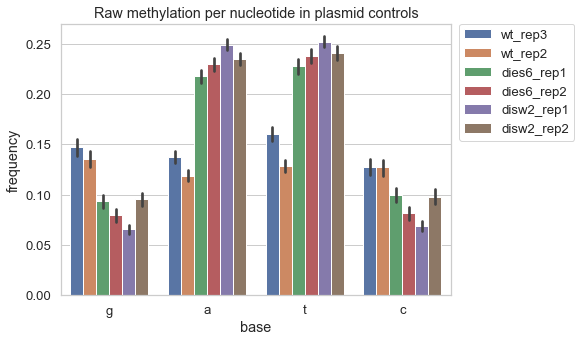

<AxesSubplot:title={'center':'Methylation frequency over samples'}, xlabel='sample', ylabel='frequency of methylation'>

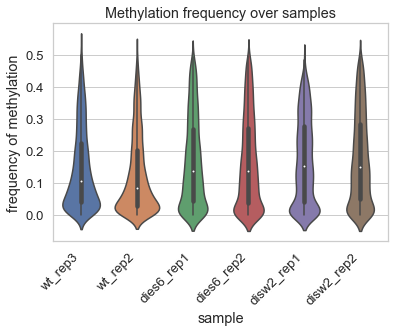

In [27]:
#prepare the data:
seq="ggaagatcctctagagtcgacccgagatcatatcactgtggacgttgatgaaagaatacgttattctttcatcaaatcgtggggctctagggtagttgcgtttctctcattgggacactgaacctcattttccaacattttggtcatgtaagaggcgacaggctcatcgcaggtgggtgcatcaacatggtagtacctggaccaagcgctacattgagtccctcctggataaacaccgctacaatattgtctttggacgtttgcccaaaccatatcttttgaataccaaagctggaccacattgtatggcctaatcattggtgctaccataatactggattgggaaacagtctggttaatttttttcaaccaatttttcttatctagcaatgatttaataaacctgaaatctaaattgtcttcgttagcgtctgtgtcataatctacaattgagtactgtgacgtccaattatatggcaccgagatggggaatctgtccggtgtttcgtcgctgttatccttctcctccctccaaatgaattcctgcagcccgggggatccactagttctagagcggccgccaccgcggtggagctccagcttttgttccctttagtgagggttaatttcgagcttggcgtaatcatggtcatagctgtttcctgtgtgaaattgttatccgctcacaattccacacaacatacgagccggaagcataaagtgtaaagcctggggtgcctaatgagtgagctaactcacattaattgcgttgcgctcactgcccgctttccagtcgggaaacctgtcgtgccagctgcattaatgaatcggccaacgcgcggggagaggcggtttgcgtattgggcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcatagctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaaggacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagttaccaatgcttaatcagtgaggcacctatctcagcgatctgtctatttcgttcatccatagttgcctgactccccgtcgtgtagataactacgatacgggagggcttaccatctggccccagtgctgcaatgataccgcgagacccacgctcaccggctccagatttatcagcaataaaccagccagccggaagggccgagcgcagaagtggtcctgcaactttatccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgcaaaaaagcggttagctccttcggtcctccgatcgttgtcagaagtaagttggccgcagtgttatcactcatggttatggcagcactgcataattctcttactgtcatgccatccgtaagatgcttttctgtgactggtgagtactcaaccaagtcattctgagaatagtgtatgcggcgaccgagttgctcttgcccggcgtcaatacgggataataccgcgccacatagcagaactttaaaagtgctcatcattggaaaacgttcttcggggcgaaaactctcaaggatcttaccgctgttgagatccagttcgatgtaacccactcgtgcacccaactgatcttcagcatcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatgagcggatacatatttgaatgtatttagaaaaataaacaaataggggttccgcgcacatttccccgaaaagtgccacctaaattgtaagcgttaatattttgttaaaattcgcgttaaatttttgttaaatcagctcattttttaaccaataggccgaaatcggcaaaatcccttataaatcaaaagaatagaccgagatagggttgagtgttgttccagtttggaacaagagtccactattaaagaacgtggactccaacgtcaaagggcgaaaaaccgtctatcagggcgatggcccactacgtgaaccatcaccctaatcaagttttttggggtcgaggtgccgtaaagcactaaatcggaaccctaaagggagcccccgatttagagcttgacggggaaagccggcgaacgtggcgagaaaggaagggaagaaagcgaaaggagcgggcgctagggcgctggcaagtgtagcggtcacgctgcgcgtaaccaccacacccgccgcgcttaatgcgccgctacagggcgcgtcccattcgccattcaggctgcgcaactgttgggaagggcgatcggtgcgggcctcttcgctattacgccagctggcgaaagggggatgtgctgcaaggcgattaagttgggtaacgccagggttttcccagtcacgacgttgtaaaacgacggccagtgaattgtaatacgactcactatagggcgaattgggtaccgggccccccctcgaggtcgacggtatcgataagcttttttgggtcctttgttttcgttgtttcagtctggataaattttaagttaccattatcgaaggcacttttgtacttgtcactaattaaagatgcaatgtcagcggggatactcatttttattttaatttttacttttctgtttgttctaaaatctatctaaactggctttcaagatcaatctattgtcttttaaggtaaactttaaattggaaataatagtaatgttagttccttcattttaaccttgtattgtatttcctttgcgtgatgaaaaaaaaactgaaaaagagaaaaataagaaaatcttctagaacgttccgaaacaggacacttagcacacaaatacagaataggaaagtaaaaggcaatatatgaatgcagtgcttgtaactggtgcttgtatccaagaatagcttcttgctgtaggttatgggaatatcgtgtaagctggggtgacttttgagctattcgcgacgcccgacgccgtaataactactttctcgacccgagatcatatcactgtggacgttgatgaaagaatacgttattctttcatcaaatcgtggtcgaccggcatgcaagctccctcgaggacagaccacttatgacagtatttcaggccgctcttataaaatgacatgttaacaaacagttctgattattcgccttttgacaggacgataatgtaaatagttgtggtagtatcattcaggtatgtaactgtttactttgtatcgcttgaaaaaaataagcatttcagagccttctttggagctcaagtggattgaggccacagcaagaccggccagtttgaatgctcaactcttcaaaagaaattcctcaaatatgtccagtttcatgtactgtccggtgtgatttattattttttatttactttgtagttcttaaagctaagatttttttctttgataaattcttgttttcatatcctaaaattaaagggaaaataaacaatacataacaaaacatataaaaaccaacacaataaaaaaaaggatcaaatactcattaaagtaacttacacgggggctaaaaacggagtttgatgaatattcacaagataaaaatcatatgtatgtttctgatatatcgatatacaatcaaacactttcaagaatttgtttgtagactttttgctagagacctcatcaaagtgctaccaactaagatcaacttatacttcttttagagaaaatttttttcaatgtactccaaagagatttagatcctgtctcttcctcttcctcttcctcgaaagtcaaagaaaaatcagagtctccc"
seq = seq.lower()

eff_df = pd.DataFrame({"wt_rep3": wt_rep3_plasmid_join.mean(axis=0)}, index=range(4791)) 

eff_df["base"] = [letter for letter in seq]

eff_df["wt_rep2"] = wt_rep2_plasmid_join.mean(axis=0)
eff_df["dies6_rep1"] = dies6_rep1_plasmid_join.mean(axis=0)
eff_df["dies6_rep2"] = dies6_rep2_plasmid_join.mean(axis=0)
eff_df["disw2_rep1"] = disw2_rep1_plasmid_join.mean(axis=0)
eff_df["disw2_rep2"] = disw2_rep2_plasmid_join.mean(axis=0)

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Raw methylation per nucleotide in plasmid controls")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Methylation frequency over samples")

g

In [30]:
#normalise to the mean methylation levels of the nucleosomal array:

wt_rep3_minmax = wt_rep3_plasmid_join.mean(axis = 0)/wt_rep3_join.flatten().mean(axis=0)
wt_rep2_minmax = wt_rep2_plasmid_join.mean(axis = 0)/wt_rep2_join.flatten().mean(axis=0)

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1_plasmid_join.mean(axis = 0)/dies6_rep1_join.flatten().mean(axis=0)
dies6_rep2_minmax = dies6_rep2_plasmid_join.mean(axis = 0)/dies6_rep2_join.flatten().mean(axis=0)

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1_plasmid_join.mean(axis = 0)/disw2_rep1_join.flatten().mean(axis=0)
disw2_rep2_minmax = disw2_rep2_plasmid_join.mean(axis = 0)/disw2_rep2_join.flatten().mean(axis=0)

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

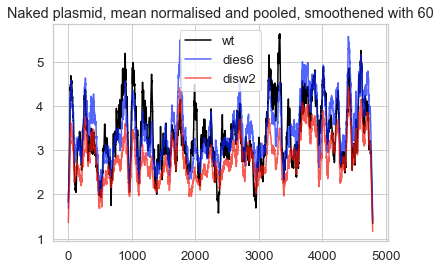

In [32]:
N=60 #smoothening window size

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), 
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"),
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Naked plasmid, mean normalised and pooled, smoothened with " + str(N))

plt.show()